In [7]:
from kaveh.behavioral.oculomotor.session import session
from kaveh.toolbox import find_file
from neo.io import Spike2IO
from matplotlib import pyplot as plt
import numpy as np



In [8]:
import os
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
import sklearn.preprocessing as pp

In [109]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
buckley_files_correct_events = ['B082107_1340_List.smr', #yes
'B090407_1526_List.smr', # yes
# 'B091208_1545_List.smr', # No done
# 'B091608_1208_List.smr', # No done
'B091707_1414_List.smr', # No done
'B091908_1_1500_List.smr', # No done
'B091908_2_1550_List.smr', # No done
'B093008_1149_List.smr', # No done
'B100308_2_1403_List.smr', # No done
'W091008_1241_List.smr', # No done
'W091208_1337_List.smr', # No done: bimodal cs-on
'W120208_1_1418_List.smr', # No done
'W120508_1_1420_List.smr', # No done
'W120508_2_1628_List.smr'] # No


f_index =4
f_name = find_file(buckley_files_correct_events[f_index], '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt')
f_name_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.csv', '../data/david_neurons')
f_name_session = find_file(buckley_files_correct_events[f_index]+'.pkl.session.pkl', '../data/david_neurons')
f_name_gmm_csv = find_file(buckley_files_correct_events[f_index]+'.pkl.GMM.CS.csv', '../data/david_neurons')
print(f_name)
print(f_name_csv)
print(f_name_session)
print(f_name_gmm_csv)

/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2010_Adapt/Buckley_12deg/B091908_2/B091908_2_1550_List.smr
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.csv
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.session.pkl
../data/david_neurons/B091908_2/B091908_2_1550_List.smr.pkl.GMM.CS.csv


In [169]:
neo_reader = Spike2IO(filename=f_name)
neo_data = neo_reader.read()
data_block = neo_data[0]
seg = data_block.segments[0]

In [170]:
# Load cs times from csGUI csv files
import csv
t_signal = seg.analogsignals[-1].times

with open(f_name_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times = t_signal[cs_indices]
cs_times.shape

(365,)

In [171]:
# Load cs times from GMM csv files
import csv
t_signal = seg.analogsignals[-1].times

with open(f_name_gmm_csv, 'r') as csv_f:
    reader = csv.reader(csv_f)
    csv_content = np.array(list(reader), dtype=np.int64)

cs_indices_gmm = np.squeeze(csv_content[np.where(csv_content[:,1] == 1), 0])
cs_times_gmm = t_signal[cs_indices_gmm]
cs_times_gmm.shape

(556,)

In [172]:
with open(f_name_session, 'rb') as input:
    try:
        mysess = pickle.load(input, encoding='latin1')
    except TypeError:
        mysess = pickle.load(input)



In [173]:
# find inra-saccadic target jumps. For each saccade, check if that saccade is accompanied by a simultaneous target jump.
# If so, it is an intra-saccadic target_jump. 
# check 25 ms before and after the saccade onset and offset for the target jump onset and offset. if found, the target jump is intra-saccadic
import numpy as np
import quantities as pq
iss_range = pq.quantity.Quantity(0.050, 's')
iss_targets = []
iss_saccades = []
saccades_with_no_iss_target = []
for i, (son, soff) in enumerate(zip(mysess.saccade_onset_times, mysess.saccade_offset_times)):
    iss_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])
    if iss_targets[-1].size != 0:
        iss_saccades.append(i)
    if iss_targets[-1].size == 0:
        saccades_with_no_iss_target.append(i)
        
iss_targets = np.squeeze(np.array([isst[0] for isst in iss_targets if isst.size != 0]))

In [174]:
iss_multipeak_targets = []
for i, (son, soff) in enumerate(zip(mysess.multipeak_saccade_onsets, mysess.multpeak_saccade_offsets)):
    iss_multipeak_targets.append(np.where(np.logical_or(np.logical_and(mysess.target_onset_times < son + iss_range, 
                                                             mysess.target_onset_times > son - iss_range), 
                                              np.logical_and(mysess.target_offset_times < soff + iss_range, 
                                                             mysess.target_offset_times > soff - iss_range)))[0])

iss_multipeak_targets = np.squeeze(np.array([isst[0] for isst in iss_multipeak_targets if isst.size != 0]))

In [175]:
non_iss_target_jumps = np.setdiff1d(np.arange(mysess.target_onset_times.size), np.union1d(iss_targets, iss_multipeak_targets))

In [176]:
# calculate target vectors (target_offset_position - target_onset_position)
ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

target_jump_H = toff_HT - ton_HT
target_jump_V = toff_VT - ton_VT

target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)



In [177]:
bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [178]:
bin_ind[bin_ind == 8] = 0

In [179]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)


In [163]:

mysess.target_offset_times[non_iss_target_jumps][np.where(mysess.target_offset_times[non_iss_target_jumps] < 400)]

array([2.7070000e-02, 6.2907000e-01, 1.4450700e+00, 3.0480700e+00,
       3.8600700e+00, 5.4630700e+00, 6.2900700e+00, 7.8930700e+00,
       8.7280700e+00, 1.0330070e+01, 1.1149070e+01, 1.2752070e+01,
       1.3557070e+01, 1.5159070e+01, 1.5922070e+01, 1.7524070e+01,
       1.8342070e+01, 1.9944070e+01, 2.0758070e+01, 2.2361070e+01,
       2.3134070e+01, 2.4736070e+01, 2.5549070e+01, 2.7152070e+01,
       2.7962070e+01, 2.9564070e+01, 3.0362070e+01, 3.1965070e+01,
       3.2750070e+01, 3.4352070e+01, 3.5135070e+01, 3.6737070e+01,
       3.7617070e+01, 3.9219070e+01, 4.0051070e+01, 4.1653070e+01,
       4.2438070e+01, 4.4040070e+01, 4.4873070e+01, 4.6476070e+01,
       4.7293070e+01, 4.8895070e+01, 4.9685070e+01, 5.1288070e+01,
       5.2089070e+01, 5.3691070e+01, 5.4480070e+01, 5.6082070e+01,
       5.6892070e+01, 5.8495070e+01, 5.9325070e+01, 6.0928070e+01,
       6.1706070e+01, 6.3308070e+01, 6.4141070e+01, 6.5744070e+01,
       6.6554070e+01, 6.8156070e+01, 6.8960070e+01, 7.0562070e

In [180]:
[count, prob, bin_size] = get_bin_cs_counts(0.200, mysess.target_offset_times[non_iss_target_jumps][np.where(mysess.target_offset_times[non_iss_target_jumps] < 510)],
                                            bin_ind[np.where(mysess.target_offset_times[non_iss_target_jumps] < 510)], np.unique(bin_ind), cs_times)

In [149]:
np.count_nonzero(cs_times<510)

359

In [181]:
[count_gmm, prob_gmm, bin_size_gmm] = get_bin_cs_counts(0.200, mysess.target_offset_times[non_iss_target_jumps][np.where(mysess.target_offset_times[non_iss_target_jumps] < 510)],
                                            bin_ind[np.where(mysess.target_offset_times[non_iss_target_jumps] < 510)], np.unique(bin_ind), cs_times_gmm)

<IPython.core.display.Javascript object>


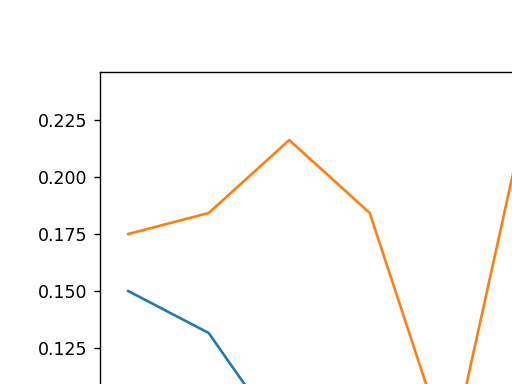

In [182]:
plt.figure()

plt.plot(prob)
plt.plot(prob_gmm)
plt.legend(['manual', 'gmm'])



In [183]:
plt.savefig('../data/plots/cs-tuning-gmm-man-compare3.png')

<IPython.core.display.Javascript object>


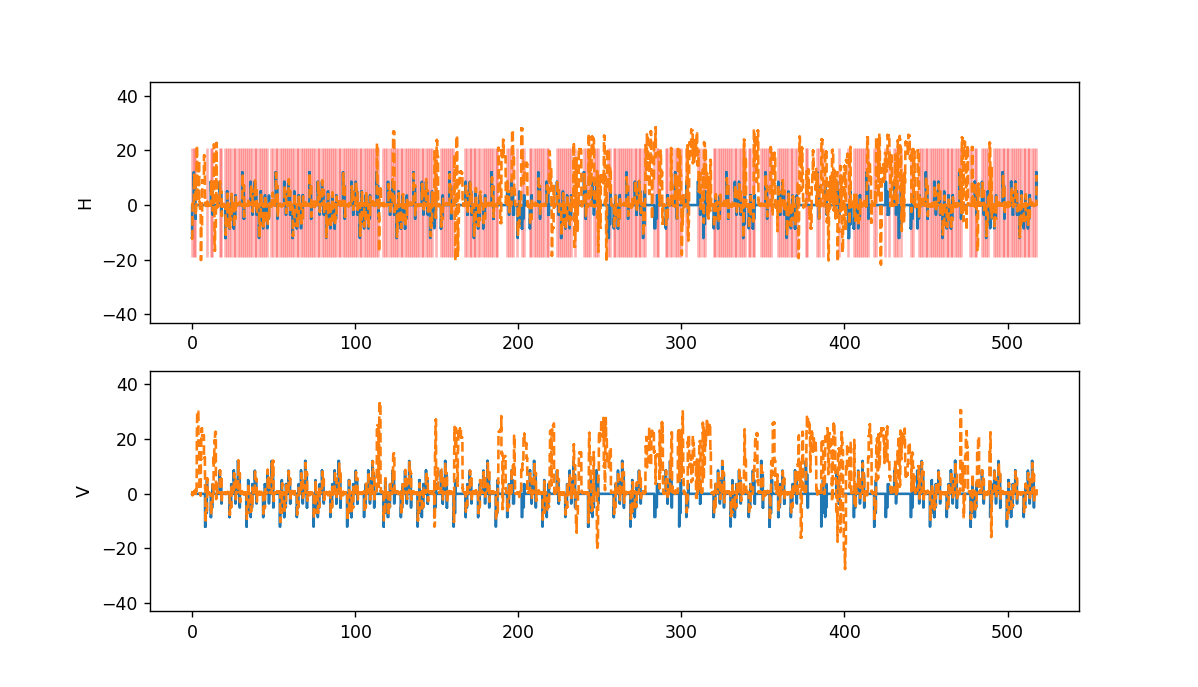

In [150]:
import gc
gc.collect()

plt.figure()

ax1 = plt.subplot(211)
plt.plot(mysess.t_HT, mysess.HT)
plt.plot(mysess.t_HE, mysess.HE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.3)
plt.ylabel('H')

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(mysess.t_VT, mysess.VT)
plt.plot(mysess.t_VE, mysess.VE, '--')
plt.ylabel('V')
plt.show()

In [61]:
# calculate target vectors (target_offset_position - target_onset_position)
ton_VT = np.squeeze(mysess.VT[mysess.target_onsets[non_iss_target_jumps]])
toff_VT = np.squeeze(mysess.VT[mysess.target_offsets[non_iss_target_jumps]])

ton_HT = np.squeeze(mysess.HT[mysess.target_onsets[non_iss_target_jumps]])
toff_HT = np.squeeze(mysess.HT[mysess.target_offsets[non_iss_target_jumps]])

target_jump_H = toff_HT - ton_HT
target_jump_V = toff_VT - ton_VT

target_jump_dir = np.arctan2(target_jump_V, target_jump_H) * 180 / np.pi

target_jump_mag = np.linalg.norm(np.vstack((target_jump_H, target_jump_V)), axis = 0)




In [57]:
t_start = 0
t_end = 5000
mysess = session(HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))], t_HT[np.where(np.logical_and((t_HT > t_start), (t_HT <= t_end)))],
                 VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))], t_VT[np.where(np.logical_and((t_VT > t_start), (t_VT <= t_end)))],
                 HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))], t_HE[np.where(np.logical_and((t_HE > t_start), (t_HE <= t_end)))],
                 VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], t_VE[np.where(np.logical_and((t_VE > t_start), (t_VE <= t_end)))], fs, dt)
mysess._cut_to_min_size()
mysess._calc_target_velocity()
mysess._calc_saccade_velocity()
mysess._detect_target_jumps()
mysess._detect_saccades()
mysess._calc_error_vectors()


In [62]:
bin_ind = np.digitize(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [73]:
bin_ind [bin_ind == 8] = 0

In [72]:
np.arange(-180 + 22.5, 180, 45)

array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5])

In [74]:
np.unique(bin_ind)

array([0, 1, 2, 3, 4, 5, 6, 7])

<IPython.core.display.Javascript object>


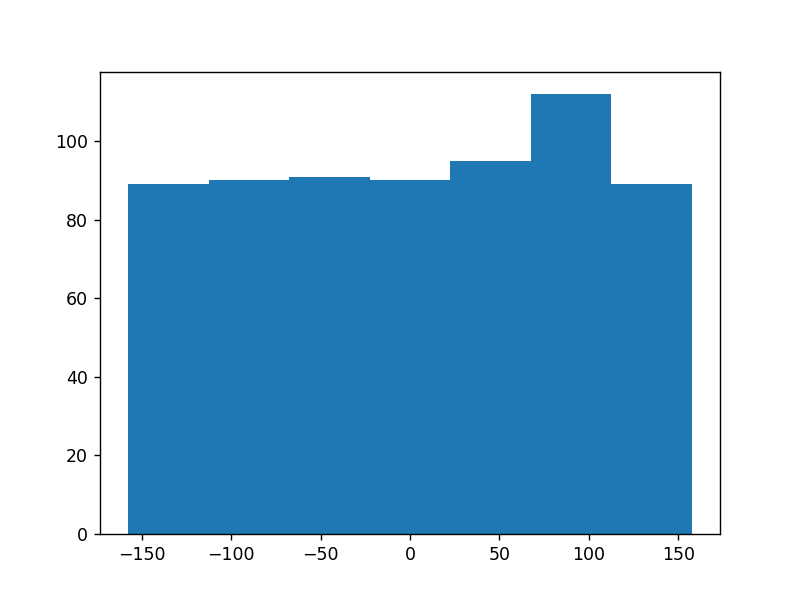

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [66]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))

In [63]:
import quantities as pq

def get_bin_cs_counts(cs_range, event_times, bin_ind, error_dir_bin_numbers, cs_times):
    '''
    get cs_counts for each bin
    '''
    cs_range = pq.quantity.Quantity(cs_range, 's')
    bin_cs_counts = []
    bin_cs_prob = []
    bin_size = []
    for ebn in error_dir_bin_numbers:
        bin_times = event_times[bin_ind == ebn]
        cs_count = 0
        if bin_times.size != 0:
            for bt in bin_times:
                cs_count = cs_count + np.count_nonzero(np.where(np.logical_and(cs_times < bt+cs_range, cs_times > bt )))
            cs_prob = cs_count*1.0/bin_times.size
            bin_cs_prob.append(cs_prob)
            bin_cs_counts.append(cs_count)
            bin_size.append(bin_times.size)
        else:
            bin_cs_counts.append(0)
            bin_cs_prob.append(0)
            bin_size.append(0)
        
    bin_cs_counts = np.array(bin_cs_counts)
    bin_cs_prob = np.array(bin_cs_prob)
    bin_size = np.array(bin_size)
#     bin_cs_counts = bin_cs_counts*1.0/np.sum(bin_cs_counts)
    return (bin_cs_counts, bin_cs_prob, bin_size)


In [64]:
get_bin_cs_counts(0.200, mysess.target_offset_times[non_iss_target_jumps], bin_ind, np.array([1, 5]), cs_times)

(array([17, 18]), array([0.19101124, 0.18947368]), array([89, 95]))

In [123]:
bin_number = 7
saccade_response_delays_to_target_presentation = []
saccade_delays_target_offset_times = []
for toff in mysess.target_offset_times[non_iss_target_jumps][bin_ind == bin_number]:
    delay_to_next_saccade = mysess.saccade_onset_times[np.argmax(mysess.saccade_onset_times > toff)] - toff
    delay_to_next_target_jump = mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number][np.argmax(mysess.target_onset_times[non_iss_target_jumps][bin_ind == bin_number] > toff)] - toff
    if delay_to_next_saccade <= delay_to_next_target_jump and delay_to_next_saccade <= 0.6:
        saccade_response_delays_to_target_presentation.append(delay_to_next_saccade)
        saccade_delays_target_offset_times.append(toff)

saccade_response_delays_to_target_presentation = np.squeeze(np.array(saccade_response_delays_to_target_presentation))
saccade_delays_target_offset_times = np.squeeze(np.array(saccade_delays_target_offset_times))

In [124]:
saccade_delays_target_offset_times =  pq.quantity.Quantity(saccade_delays_target_offset_times, 's')

In [130]:
bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.050)
bin_ind_sac_delays = np.digitize(saccade_response_delays_to_target_presentation, bins = bins)
bins

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55])

In [131]:
bin_means = [saccade_response_delays_to_target_presentation[bin_ind_sac_delays == i].mean() for i in np.unique(bin_ind_sac_delays)]

In [132]:
(cs_counts, cs_probs, bin_sizes) = get_bin_cs_counts(0.150, saccade_delays_target_offset_times, bin_ind_sac_delays, np.unique(bin_ind_sac_delays), cs_times)

<IPython.core.display.Javascript object>


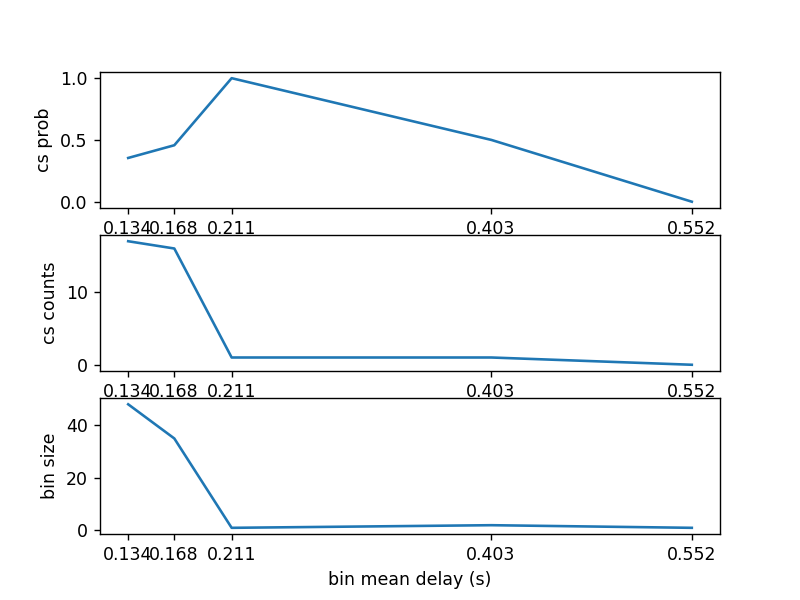

Text(0.5,0,u'bin mean delay (s)')

In [133]:
plt.figure()

plt.subplot(311)
plt.plot(bin_means,  cs_probs)
plt.xticks(np.round(bin_means,3))
plt.ylabel('cs prob')

plt.subplot(312)
plt.plot(bin_means,  cs_counts)
plt.xticks(np.round(bin_means,3))
plt.ylabel('cs counts')

plt.subplot(313)
plt.plot(bin_means,  bin_sizes)
plt.xticks(np.round(bin_means,3))
plt.ylabel('bin size')
plt.xlabel('bin mean delay (s)')

# plt.ylabel('prob of cs in 0.250 after target present')

<IPython.core.display.Javascript object>


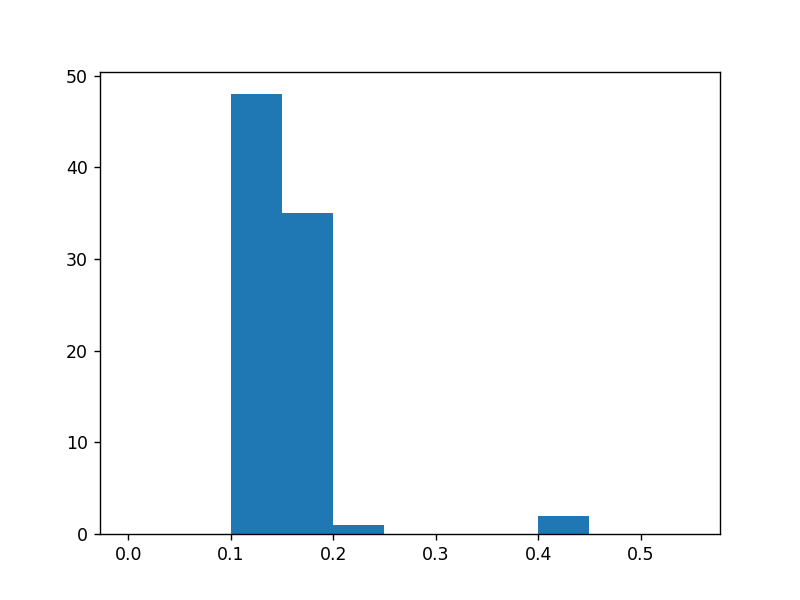

(array([ 0.,  0., 48., 35.,  1.,  0.,  0.,  0.,  2.,  0.,  0.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55]),
 <a list of 11 Patch objects>)

In [129]:
plt.figure()
plt.hist(saccade_response_delays_to_target_presentation, bins = np.arange(0, np.max(saccade_response_delays_to_target_presentation), 0.05))

<IPython.core.display.Javascript object>


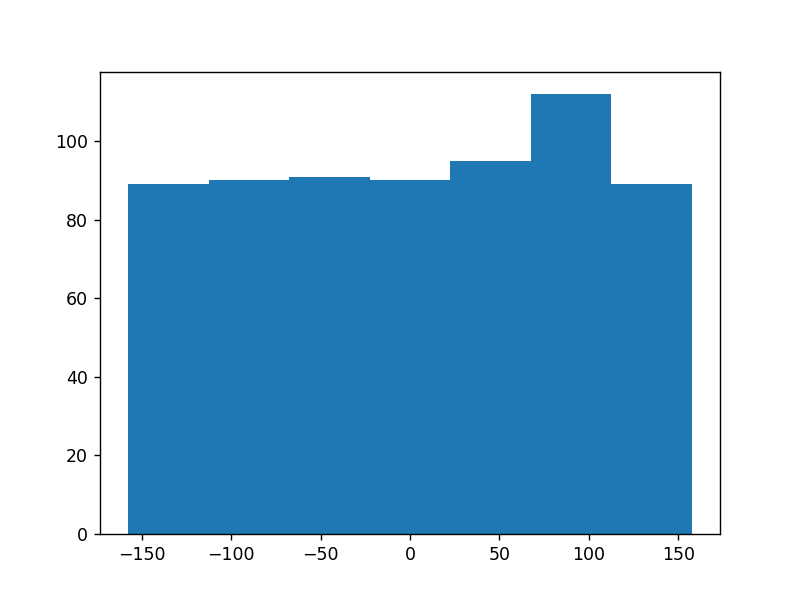

(array([ 89.,  90.,  91.,  90.,  95., 112.,  89.]),
 array([-157.5, -112.5,  -67.5,  -22.5,   22.5,   67.5,  112.5,  157.5]),
 <a list of 7 Patch objects>)

In [134]:
plt.figure()
plt.hist(target_jump_dir, bins = np.arange(-180 + 22.5, 180, 45))


<IPython.core.display.Javascript object>


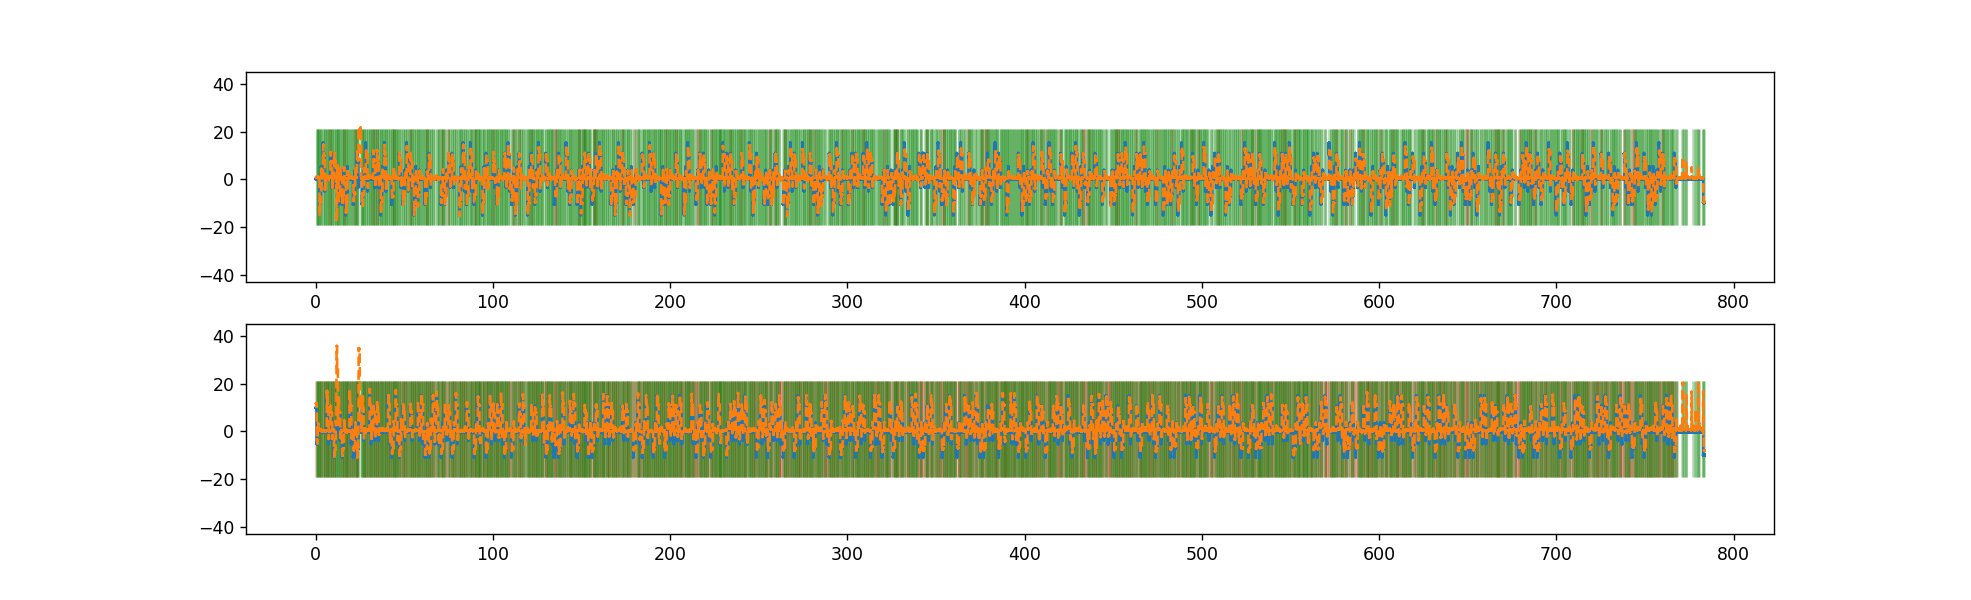

In [135]:
import gc
gc.collect()

plt.figure()
ax1 = plt.subplot(211)
plt.plot(t_HT, HT)
plt.plot(t_HE, HE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps][bin_ind == 5], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

ax2 = plt.subplot(212, sharex=ax1, sharey=ax1)
plt.plot(t_VT, VT)
plt.plot(t_VE, VE, '--')
plt.eventplot(mysess.target_onset_times[non_iss_target_jumps], linelengths=40, colors='r', alpha = 0.3)
plt.eventplot(mysess.saccade_onset_times, linelengths=40, color = 'g', alpha = 0.3)

plt.show()

In [140]:
# saving mysess
output_fn = f_name_csv + '.session.pkl'
with open(output_fn, 'wb') as output:
    print('writing {} ...'.format(output_fn))
    pickle.dump(mysess, output, pickle.HIGHEST_PROTOCOL)


writing ../data/david_neurons/K45/error_direction/K45_1_ErrorDirectionTest.smr.pkl.csv.session.pkl ...
